In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

LATENT_DIM = 512
IMG_CHANNELS = 3


In [2]:
def mapping_network(latent_dim, layers=8):
    model = tf.keras.Sequential(name="mapping_network")
    for _ in range(layers):
        model.add(tf.keras.layers.Dense(latent_dim, activation="relu"))
    return model

mapping_net = mapping_network(LATENT_DIM)


In [3]:
class AdaIN(tf.keras.layers.Layer):
    def call(self, inputs):
        content, style = inputs
        mean, variance = tf.nn.moments(content, axes=[1, 2], keepdims=True)
        normalized = (content - mean) / tf.sqrt(variance + 1e-8)
        scale, bias = style
        return scale * normalized + bias


In [4]:
def progressive_block(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    return tf.keras.Model(inputs, x)


In [5]:
def build_generator():
    z = tf.keras.Input(shape=(LATENT_DIM,))
    mapping = mapping_network(LATENT_DIM)
    w = mapping(z)

    x = tf.keras.layers.Dense(4 * 4 * 128)(w)
    x = tf.keras.layers.Reshape((4, 4, 128))(x)

    block = progressive_block((4, 4, 128))
    x = block(x)

    x = tf.keras.layers.Conv2D(
        IMG_CHANNELS, kernel_size=1, activation="tanh"
    )(x)

    return tf.keras.Model(z, x, name="generator")

generator = build_generator()
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 mapping_network (Sequentia  (None, 512)               2101248   
 l)                                                              
                                                                 
 dense_16 (Dense)            (None, 2048)              1050624   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 model (Functional)          (None, 8, 8, 64)          221376    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 3)           195       
                                                         

In [6]:
def build_discriminator():
    inputs = tf.keras.Input(shape=(8, 8, IMG_CHANNELS))
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, x, name="discriminator")

discriminator = build_discriminator()
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 8, 3)]         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          1792      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 4097      
                                                                 
Total params: 5889 (23.00 KB)
Trainable params: 5889 (23.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def visualize_images(images, rows, cols):
    images = (images + 1) / 2
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()


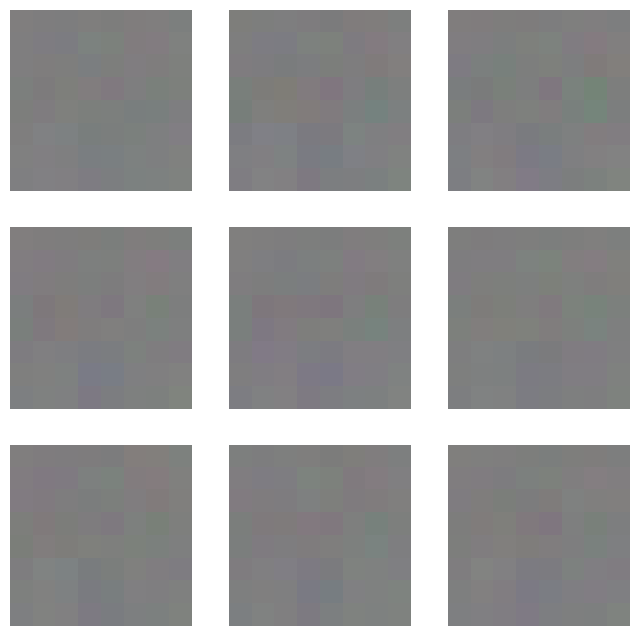

In [8]:
noise = tf.random.normal([9, LATENT_DIM])
fake_images = generator(noise)
visualize_images(fake_images.numpy(), 3, 3)
